In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

## Extra Functions

In [ ]:
def mean(numbers):
  return sum(numbers)/len(numbers)


def stdev(numbers):
  return np.std(numbers)

def discr(x, k):
  w = (np.max(x) - np.min(x)) / k
  bins = [np.min(x) + (i) * w for i in range(k)]
  return np.digitize(x, bins=bins, right=False)

## Reading Data

In [ ]:
%cd /content/drive/MyDrive/ML/data/Assignment
!pwd

/content/drive/MyDrive/ML/data/Assignment
/content/drive/MyDrive/ML/data/Assignment


In [ ]:
# Reading Mushroom dataset
df_mushroom = pd.read_csv("mushroom.data")
df_mushroom.replace("?", np.NaN).dropna()
df_mushroom.reset_index()
print("Reading Mushroom dataset (df_mushroom) ---> done ")

Reading Mushroom dataset (df_mushroom) ---> done 


In [ ]:
# Reading Car dataset
df_car = pd.read_csv("car.data")
df_car.replace("?", np.NaN).dropna()
df_car.reset_index()
#df_car.info()
print("Reading Car dataset (df_car) ---> done ")

Reading Car dataset (df_car) ---> done 


In [ ]:
# Reading Breast Cancer Wisconsin dataset
df_cancer = pd.read_csv("breast-cancer-wisconsin.data")
df_cancer.replace("?", np.NaN).dropna()
df_cancer.reset_index()
df_cancer.drop(columns=["1000025"], inplace=True)
#df_cancer.info()
#df_cancer['2.1'].unique()
print("Reading Breast Cancer Wisconsin dataset (df_cancer) ---> done ")

Reading Breast Cancer Wisconsin dataset (df_cancer) ---> done 


In [ ]:
# Reading Ecoli dataset
names = ["f_" + str(i) for i in range(8)] + ["target"]
df_ecoli = pd.read_csv("ecoli_last.data", header=0, names=names, parse_dates=True,squeeze=True)
df_ecoli.drop(columns=["f_0"], inplace=True)
df_ecoli['target'] = df_ecoli['target'].replace(['imS', 'imL', 'imU','im'], 'imSULomL')
df_ecoli['target'] = df_ecoli['target'].replace(['om', 'omL'], 'omLL')
#df_ecoli

In [ ]:
df_ecoli['f_1'] = discr(df_ecoli['f_1'].values.astype(np.float64), 19)
df_ecoli['f_2'] = discr(df_ecoli['f_2'].values.astype(np.float64), 19)
df_ecoli['f_3'] = discr(df_ecoli['f_3'].values.astype(np.float64), 2)
df_ecoli['f_4'] = discr(df_ecoli['f_4'].values.astype(np.float64), 2)
df_ecoli['f_5'] = discr(df_ecoli['f_5'].values.astype(np.float64), 19)
df_ecoli['f_6'] = discr(df_ecoli['f_6'].values.astype(np.float64), 19)
df_ecoli['f_7'] = discr(df_ecoli['f_7'].values.astype(np.float64), 19)
print("Reading Ecoli dataset (df_ecoli) ---> done ")

Reading Ecoli dataset (df_ecoli) ---> done 


In [ ]:
# Reading Ecoli dataset
df_letter = pd.read_csv("letter-recognition-ostad.data")
df_shuffeled = df_letter.sample(frac=1).reset_index()
df = df_shuffeled.drop(['index'], axis=1)
df_letter = df[ (df['T'] =='A')|(df['T'] == 'B')|(df['T']=='C')|(df['T']=='D')|(df['T']=='E')|(df['T']=='F')|(df['T']=='G')|(df['T']=='H')|(df['T']=='I')|(df['T']=='J')|(df['T']=='K')|(df['T']=='L')|(df['T']=='M')|(df['T']=='N') ]
#df_letter = df[ (df['T'] =='A')|(df['T'] == 'B')|(df['T']=='C')|(df['T']=='D')|(df['T']=='E')]
df_letter = df_letter.reset_index()
df_letter.drop(columns=["index"], inplace=True)
#df_letter.info()

In [ ]:
i=0
for columnName in df_letter:
  i+=1
  if i>1:
    for j in range(0,16):
      if ((len(df_letter[df_letter[columnName]==j])/df_letter.shape[0])*100) < 0.5:
        #print("column name: ", columnName, "   j is: ", j, "len is:  ", (len(df_letter[df_letter[columnName]==j])/df_letter.shape[0])*100, 
            #"   len itself is:  ", len(df_letter[df_letter[columnName]==j]))
        index_names = df_letter[ df_letter[columnName] == j ].index
        df_letter.drop(index_names, inplace = True)
        df_letter.reset_index(drop=True, inplace=True)
print("Reading Letter Recognition dataset (df_letter) ---> done ")

Reading Letter Recognition dataset (df_letter) ---> done 


## ID3

In [ ]:
def entropy(p):
  return (-1) * (p) * math.log2(p)
  
def d_entropy(data, label, classes): #Entropy of input data
    num_d = data.shape[0] #size of the input data
    entropy_d = 0
    
    for clas in classes: #for each class in the label
        num_class = data[data[label] == clas].shape[0] #number of the class
        if num_class!= 0:
          entropy_d += entropy(num_class/num_d) #adding entropy of class
    return entropy_d

In [ ]:
def subfeature_entropy(feature_data, label, classes): #Entropy of a subfeature = Ex: Outlook -> Sunny 
    num_feature = feature_data.shape[0]
    subfeature_entropy = 0
    
    for clas in classes:
        num_feature_class = feature_data[feature_data[label] == clas].shape[0] #row count of class c 
        entropy_feature = 0
        if num_feature_class != 0:
          entropy_feature = entropy(num_feature_class/num_feature)
        subfeature_entropy += entropy_feature
    return subfeature_entropy

In [ ]:
def gain(feature_name, data, label, classes):
    subfeature_list = data[feature_name].unique() #unqiue values of the feature
    num_d = data.shape[0]
    feature_info = 0.0
    
    for subfeature in subfeature_list:
        subfeature_data = data[data[feature_name] == subfeature] #filtering rows with that feature_value
        num_subfeature = subfeature_data.shape[0]
        feature_info += (num_subfeature/num_d) * subfeature_entropy(subfeature_data, label, classes) #calculating information of the feature value
        
    return d_entropy(data, label, classes) - feature_info #calculating information gain by subtracting

In [ ]:
def find_best_feature(data, label, classes):
    features = data.columns.drop(label) #finding the feature names in the dataset
                                            #N.B. label is not a feature, so dropping it
    max_gain = -1
    best_feature = None
    
    for feature in features:  #for each feature in the dataset
        feature_gain = gain(feature, data, label, classes)
        if max_gain < feature_gain: #selecting feature name with highest information gain
            max_gain = feature_gain
            best_feature = feature
    #print("best feature: ", best_feature)        
    return best_feature

In [ ]:
def generate_sub_tree(feature_name, data, label, classes):
    feature_dict = data[feature_name].value_counts(sort=False) #dictionary of the count of unqiue feature value
    tree = {} #sub tree or node
    
    for subfeature, num_subfeature in feature_dict.iteritems():
        subfeature_data = data[data[feature_name] == subfeature] #dataset with only feature_name = subfeature
        
        assigned_to_tree = False #flag for tracking feature_value is pure class or not
        for clas in classes: #for each class
            num_class = subfeature_data[subfeature_data[label] == clas].shape[0] #count of class c

            if num_class == num_subfeature: #count of feature_value = count of class (pure class)
                tree[subfeature] = clas #adding node to the tree
                data = data[data[feature_name] != subfeature] #removing rows with feature_value
                assigned_to_tree = True
        if not assigned_to_tree: #not pure class
            tree[subfeature] = "?" #should extend the node, so the branch is marked with ?
            
    return tree, data

In [ ]:
def make_tree(root, prev_feature_value, train_data, label, class_list):
    if train_data.shape[0] != 0: #if dataset becomes empty after updating
        max_info_feature = find_best_feature(train_data, label, class_list) #most informative feature
        tree, train_data = generate_sub_tree(max_info_feature, train_data, label, class_list) #getting tree node and updated dataset
        next_root = None
        
        if prev_feature_value != None: #add to intermediate node of the tree
            root[prev_feature_value] = dict()
            root[prev_feature_value][max_info_feature] = tree
            next_root = root[prev_feature_value][max_info_feature]
        else: #add to root of the tree
            root[max_info_feature] = tree
            next_root = root[max_info_feature]
        
        for node, branch in list(next_root.items()): #iterating the tree node
            if branch == "?": #if it is expandable
                feature_value_data = train_data[train_data[max_info_feature] == node] #using the updated dataset
                make_tree(next_root, node, feature_value_data, label, class_list) #recursive call with updated dataset

In [ ]:
def id3(train_data_m, label):
    train_data = train_data_m.copy() #getting a copy of the dataset
    tree = {} #tree which will be updated
    class_list = train_data[label].unique() #getting unqiue classes of the label
    make_tree(tree, None, train_data_m, label, class_list) #start calling recursion
    return tree

In [ ]:
def predict(tree, instance):
    if not isinstance(tree, dict): #if it is leaf node
        return tree #return the value
    else:
        root_node = next(iter(tree)) #getting first key/feature name of the dictionary
        feature_value = instance[root_node] #value of the feature
        if feature_value in tree[root_node]: #checking the feature value in current tree node
            return predict(tree[root_node][feature_value], instance) #goto next feature
        else:
            return None

## KFold

In [ ]:
def evaluate(tree, test_data_m, label):
    correct_preditct = 0
    wrong_preditct = 0
    for index, row in test_data_m.iterrows(): #for each row in the dataset
        result = predict(tree, test_data_m.iloc[index]) #predict the row
        if result == test_data_m[label].iloc[index]: #predicted value and expected value is same or not
            correct_preditct += 1 #increase correct count
        else:
            wrong_preditct += 1 #increase incorrect count
    accuracy = correct_preditct / (correct_preditct + wrong_preditct) #calculating accuracy
    return accuracy

In [ ]:
def kfold (data, k):#seperating dataset into k folds
  range_rows = math.floor(data.shape[0]/k)
  reminder_rows = data.shape[0]%k
  fold_list = [pd.DataFrame() for x in range(k)]
  for i in range(k):
    y = 0
    if (i+1)==k:
     y = reminder_rows

    fold_list[i] = data.loc[i*range_rows:(i+1)*range_rows-1+y]

  return fold_list

In [ ]:
def applyKfold(data, kf, label):#applying k fold strategy
  accuracy = []
  train_folds = []
  folds = kfold(data, kf)
  for i in range(kf):
    test_data = pd.concat([folds[i]], ignore_index=True)
    train_folds.clear()
    for j in range(kf):
      if i!=j:
        train_folds.append(j)

    train_data = pd.concat([folds[train_folds[0]], folds[train_folds[1]], folds[train_folds[2]], folds[train_folds[3]]], ignore_index=True)
    tree = {}
    tree = id3(train_data, label)
    accuracy.append(evaluate(tree, test_data, label))
  return sum(accuracy)/len(accuracy)

In [ ]:
def nkfold(data, iteration, n, label):#iterating iteration times of n fold
  total_accuracy = []
  for i in range(iteration):
    df_shuffeled = data.sample(frac=1).reset_index()
    df_shuffeled = df_shuffeled.drop(['index'], axis=1)
    total_accuracy.append(applyKfold(df_shuffeled, n, label))
    print("Accuracy of iteration  ", i,  "  is --->> ", total_accuracy[i])
  return total_accuracy

## Main_Mushroom

In [ ]:
total_accuracy_mushroom = nkfold(df_mushroom, 10, 5, 'p')
print("total accuracy of Mushroom dataset: ", total_accuracy_mushroom)
mean = sum(total_accuracy_mushroom)/len(total_accuracy_mushroom)
standard_deviation = stdev(total_accuracy_mushroom)
print("Standard Deviation of Mushroom dataset : " + str(standard_deviation))
print("Mean Accuracy of 10 Times 5 Fold of Mushroom: " + str(mean))

Accuracy of iteration   0   is --->>  1.0
Accuracy of iteration   1   is --->>  1.0
Accuracy of iteration   2   is --->>  1.0
Accuracy of iteration   3   is --->>  1.0
Accuracy of iteration   4   is --->>  1.0
Accuracy of iteration   5   is --->>  1.0
Accuracy of iteration   6   is --->>  1.0
Accuracy of iteration   7   is --->>  1.0
Accuracy of iteration   8   is --->>  1.0
Accuracy of iteration   9   is --->>  1.0
total accuracy of Mushroom dataset:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Standard Deviation of Mushroom dataset : 0.0
Mean Accuracy of 10 Times 5 Fold of Mushroom: 1.0


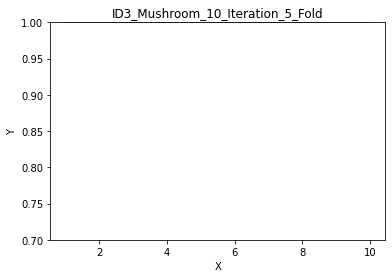

In [ ]:
x = np.array([ 1,  2,  3,  4,  5,  6,  7, 8, 9, 10 ])
y = np.array(total_accuracy_mushroom)
 
# Plotting the Graph
plt.plot(x, y)
plt.title("ID3_Mushroom_10_Iteration_5_Fold")
plt.xlabel("X")
plt.ylabel("Y")
plt.ylim(0.7, 1.0)
plt.show()

## Main_Car

In [ ]:
total_accuracy_car = nkfold(df_car, 10, 5, 'unacc')
print("total accuracy of Car dataset: ", total_accuracy_car)
mean = sum(total_accuracy_car)/len(total_accuracy_car)
standard_deviation = stdev(total_accuracy_car)
print("Standard Deviation of Car dataset : " + str(standard_deviation))
print("Mean Accuracy of 10 Times 5 Fold of Car: " + str(mean))

Accuracy of iteration   0   is --->>  0.892327611410433
Accuracy of iteration   1   is --->>  0.8824558326024308
Accuracy of iteration   2   is --->>  0.8934803491625946
Accuracy of iteration   3   is --->>  0.8934569602806667
Accuracy of iteration   4   is --->>  0.8835952052792049
Accuracy of iteration   5   is --->>  0.8888159378523994
Accuracy of iteration   6   is --->>  0.8957657770538361
Accuracy of iteration   7   is --->>  0.8917512425343525
Accuracy of iteration   8   is --->>  0.9009865096270309
Accuracy of iteration   9   is --->>  0.8813097773879631
total accuracy of Car dataset:  [0.892327611410433, 0.8824558326024308, 0.8934803491625946, 0.8934569602806667, 0.8835952052792049, 0.8888159378523994, 0.8957657770538361, 0.8917512425343525, 0.9009865096270309, 0.8813097773879631]
Standard Deviation of Car dataset : 0.005998307889060202
Mean Accuracy of 10 Times 5 Fold of Car: 0.8903945203190913


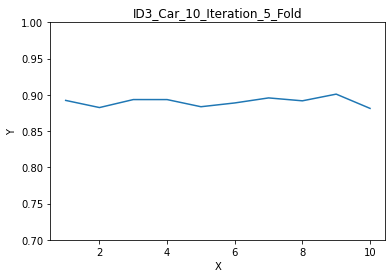

In [ ]:
x = np.array([ 1,  2,  3,  4,  5,  6,  7, 8, 9, 10 ])
y = np.array(total_accuracy_car)
 
# Plotting the Graph
plt.plot(x, y)
plt.title("ID3_Car_10_Iteration_5_Fold")
plt.xlabel("X")
plt.ylabel("Y")
plt.ylim(0.7, 1.0)
plt.show()

## Main_Cancer

In [ ]:
total_accuracy_cancer = nkfold(df_cancer, 10, 5, '2.1')
print("Total accuracy of Breast Cancer: ", total_accuracy_cancer)
mean = sum(total_accuracy_cancer)/len(total_accuracy_cancer)
standard_deviation = stdev(total_accuracy_cancer)
print("Standard Deviation of Breast Cancer dataset : " + str(standard_deviation))
print("Mean Accuracy of 10 Times 5 Fold of Breast Cancer: " + str(mean))

Accuracy of iteration   0   is --->>  0.9069003951768163
Accuracy of iteration   1   is --->>  0.9096565001519912
Accuracy of iteration   2   is --->>  0.9183807883270848
Accuracy of iteration   3   is --->>  0.9125645962103557
Accuracy of iteration   4   is --->>  0.909656500151991
Accuracy of iteration   5   is --->>  0.9096565001519912
Accuracy of iteration   6   is --->>  0.9024014591143986
Accuracy of iteration   7   is --->>  0.901205795926639
Accuracy of iteration   8   is --->>  0.9012361941432768
Accuracy of iteration   9   is --->>  0.9154726922687202
Total accuracy of Breast Cancer:  [0.9069003951768163, 0.9096565001519912, 0.9183807883270848, 0.9125645962103557, 0.909656500151991, 0.9096565001519912, 0.9024014591143986, 0.901205795926639, 0.9012361941432768, 0.9154726922687202]
Standard Deviation of Breast Cancer dataset : 0.005586114614783021
Mean Accuracy of 10 Times 5 Fold of Breast Cancer: 0.9087131421623263


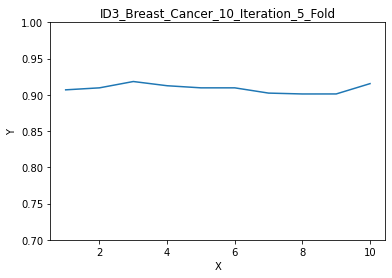

In [ ]:
x = np.array([ 1,  2,  3,  4,  5,  6,  7, 8, 9, 10 ])
y = np.array(total_accuracy_cancer)
 
# Plotting the Graph
plt.plot(x, y)
plt.title("ID3_Breast_Cancer_10_Iteration_5_Fold")
plt.xlabel("X")
plt.ylabel("Y")
plt.ylim(0.7, 1.0)
plt.show()

## Main_Ecoli

In [ ]:
total_accuracy_ecoli = nkfold(df_ecoli, 10, 5, 'target')
print("total accuracy of Ecoli dataset: ", total_accuracy_ecoli)
mean = sum(total_accuracy_ecoli)/len(total_accuracy_ecoli)
standard_deviation = stdev(total_accuracy_ecoli)
print("Standard Deviation of Ecoli dataset : " + str(standard_deviation))
print("Mean Accuracy of 10 Times 5 Fold of Ecoli: " + str(mean))

Accuracy of iteration   0   is --->>  0.7014925373134329
Accuracy of iteration   1   is --->>  0.6537313432835822
Accuracy of iteration   2   is --->>  0.7104477611940299
Accuracy of iteration   3   is --->>  0.6835820895522389
Accuracy of iteration   4   is --->>  0.6746268656716418
Accuracy of iteration   5   is --->>  0.6835820895522388
Accuracy of iteration   6   is --->>  0.6776119402985075
Accuracy of iteration   7   is --->>  0.6686567164179105
Accuracy of iteration   8   is --->>  0.6985074626865672
Accuracy of iteration   9   is --->>  0.6865671641791045
total accuracy of Ecoli dataset:  [0.7014925373134329, 0.6537313432835822, 0.7104477611940299, 0.6835820895522389, 0.6746268656716418, 0.6835820895522388, 0.6776119402985075, 0.6686567164179105, 0.6985074626865672, 0.6865671641791045]
Standard Deviation of Ecoli dataset : 0.015820895522388047
Mean Accuracy of 10 Times 5 Fold of Ecoli: 0.6838805970149253


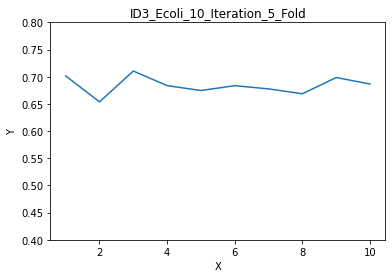

In [ ]:
x = np.array([ 1,  2,  3,  4,  5,  6,  7, 8, 9, 10 ])
y = np.array(total_accuracy_ecoli)
 
# Plotting the Graph
plt.plot(x, y)
plt.title("ID3_Ecoli_10_Iteration_5_Fold")
plt.xlabel("X")
plt.ylabel("Y")
plt.ylim(0.4, 0.8)
plt.show()

## Main Letter Recognition

In [ ]:
total_accuracy_letter = nkfold(df_letter, 10, 5, 'T')
print("total accuracy of Letter Recognition: ", total_accuracy_letter)
mean = sum(total_accuracy_letter)/len(total_accuracy_letter)
standard_deviation = stdev(total_accuracy_letter)
print("Standard Deviation of Letter Recognition : " + str(standard_deviation))
print("Mean Accuracy of 5 Times 5 Fold of Letter Recognition: " + str(mean))

Accuracy of iteration   0   is --->>  0.7848734236412519
Accuracy of iteration   1   is --->>  0.7827774162542311
Accuracy of iteration   2   is --->>  0.7869684360093372
Accuracy of iteration   3   is --->>  0.781576328897539
Accuracy of iteration   4   is --->>  0.7911605502852719
Accuracy of iteration   5   is --->>  0.7821774198362995
Accuracy of iteration   6   is --->>  0.7865685378992763
Accuracy of iteration   7   is --->>  0.7855721259375567
Accuracy of iteration   8   is --->>  0.783076220440475
Accuracy of iteration   9   is --->>  0.7867715217620591
total accuracy of Letter Recognition:  [0.7848734236412519, 0.7827774162542311, 0.7869684360093372, 0.781576328897539, 0.7911605502852719, 0.7821774198362995, 0.7865685378992763, 0.7855721259375567, 0.783076220440475, 0.7867715217620591]
Standard Deviation of Letter Recognition : 0.002754391340965056
Mean Accuracy of 5 Times 5 Fold of Letter Recognition: 0.7851521980963299


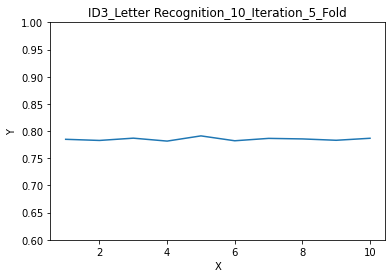

In [ ]:
x = np.array([ 1,  2,  3,  4,  5,  6,  7, 8, 9, 10 ])
y = np.array(total_accuracy_letter)
 
# Plotting the Graph
plt.plot(x, y)
plt.title("ID3_Letter Recognition_10_Iteration_5_Fold")
plt.xlabel("X")
plt.ylabel("Y")
plt.ylim(0.6, 1.0)
plt.show()